## Bike Sharing Demand
- https://www.kaggle.com/c/bike-sharing-demand
- 자전거 대여 회수를 예측

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


df = pd.read_csv('bike-sharing-demand/train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# 1. datetime을 datetime 타입으로 변경
# 2. datetime에서 년, 월, 일, 시 추출
# 3. datetime column drop

df['datetime'] = df.datetime.apply(pd.to_datetime)

df['year'] = df.datetime.apply(lambda x : x.year)
df['month'] = df.datetime.apply(lambda x : x.month)
df['day'] = df.datetime.apply(lambda x : x.day)
df['hour'] = df.datetime.apply(lambda x : x.hour)

df.drop('datetime', axis = 1, inplace = True)

In [4]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
dtype: int64

In [6]:
# 사전 등록된 사람과 사전 등록되지 않은 사람의 대여수는 예측하는데 무의미
# casual + registered = count 이므로 column이 중복되며 지나치게 높은 상관계수를 보일 위험성이 있음
# casual, registered column drop

drop_columns = ['casual', 'registered']
df.drop(drop_columns, axis = 1, inplace = True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


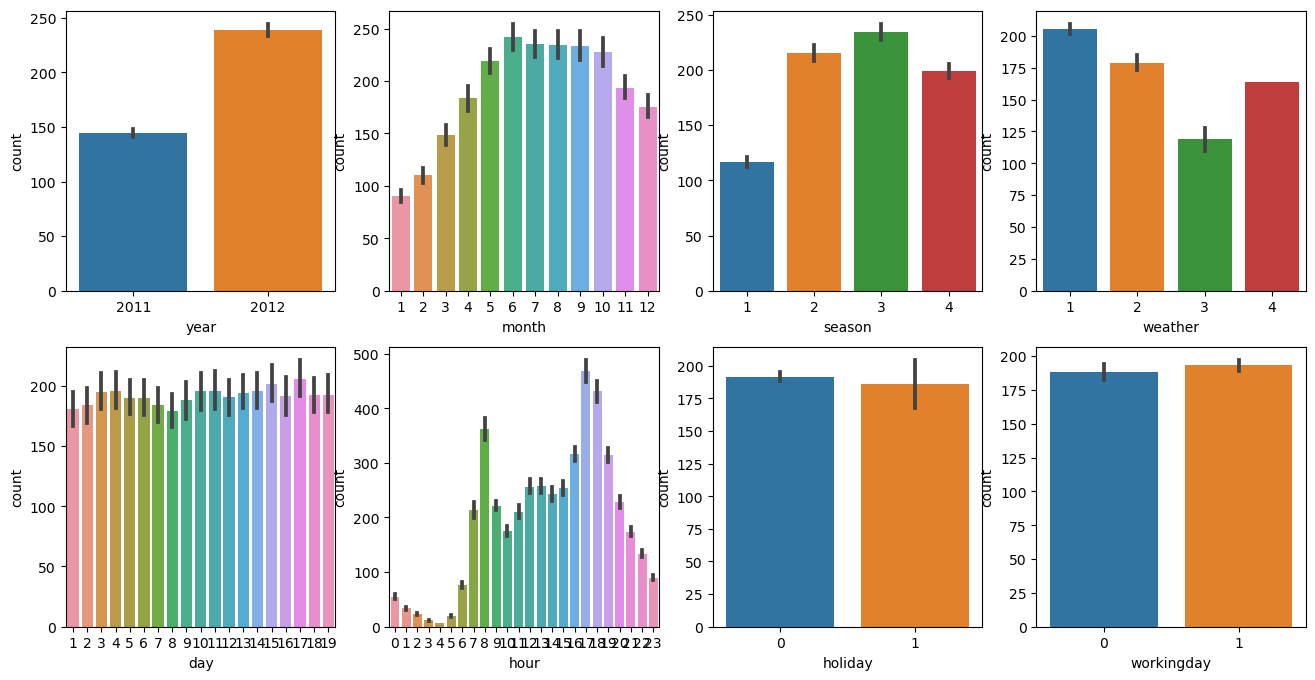

In [7]:
# column 시각화

fig, axs = plt.subplots(figsize = (16, 8), ncols = 4, nrows = 2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x = feature, y = 'count', data=df, ax = axs[row][col])

### 예측 평가를 위한 함수 구현
- RMSLE, RMSE, MSE 계산
- 이 계산을 위해 log1p, expm1을 사용
- log1p, expm1을 사용하는 이유 : 너무 작은 값을 수치 변환시 log0은 -inf가 되므로 오류 발생. 때문에 변환전 값에 1을 더한 값으로 로그를 변환할 필요가 있음 --> log1p
- log1p로 로그 변환된 값은 exam1으로 다시 원본 변환될 수 있음

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log()가 아닌 log1p를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MSE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, feature 인코딩, 모델 학습/예측/평가

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df['count']
X_features= df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MSE: 105.924


In [10]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


In [11]:
# 타깃 칼럼인 count값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmp1으로 scale 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MSE: 109.286


In [12]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef.sort_values(ascending=False)

year          0.418513
hour          0.098348
month         0.076839
atemp         0.030857
temp          0.011712
windspeed     0.003961
day           0.003353
humidity     -0.014512
weather      -0.014733
season       -0.044525
holiday      -0.046010
workingday   -0.066383
dtype: float64

<AxesSubplot:>

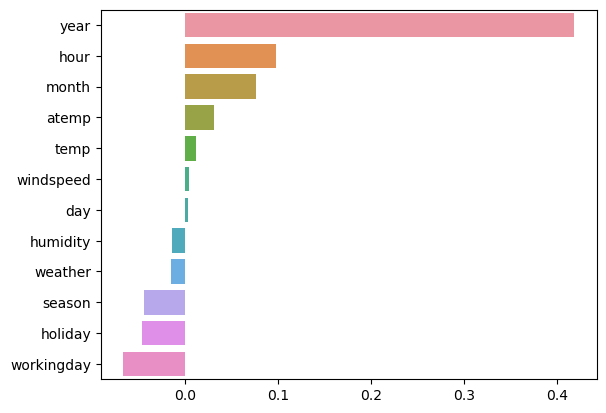

In [13]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [15]:
# 'year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather' 을 OneHot Encoding

X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [17]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [18]:
# One Hot Encoding이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MSE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MSE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MSE: 72.803


<AxesSubplot:>

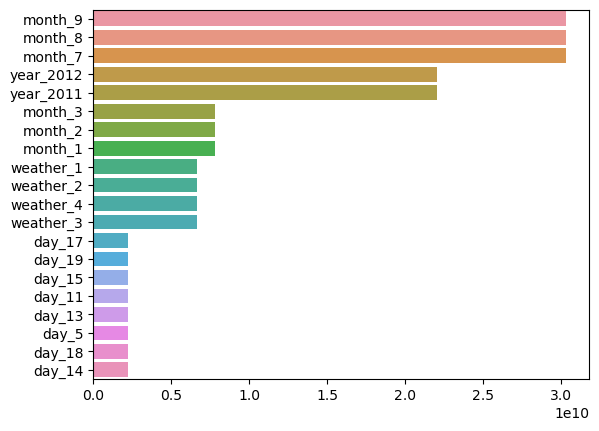

In [19]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# random forest, GBM, XGBoost, LightGBM
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)
lgbm_reg = LGBMRegressor(n_estimators = 500)

# XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생. --> ndarray로 변환
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1= True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.312, MSE: 31.196
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.329, MSE: 32.736
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MSE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MSE: 29.029
